# Coronavirus Prediction

## Overview

This project predicts related rates with deep learning methods.

## Business Understanding

We are going to have some predictions for the decision makers to layout some strategies in dealing with covid-19.

## Data Understanding

Data Collection by API

### Import Packages

In [307]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pickle

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')
#import geopandas as gpd

# import warnings
# warnings.filterwarnings('ignore')

# from pandas.plotting import register_matplotlib_converters
# # display preferences
# register_matplotlib_converters()

### Coronavirus API

https://www.programmableweb.com/api/coronavirus-tracker-rest-api-v20 \
https://covidtracking.com/data/api \
https://cord19.vespa.ai

In [137]:
# Coronavirus Tracker REST API 
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [120]:
data = pd.DataFrame(d['locations'])
data.head()

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,37172386.0,,2021-01-29T19:31:32.703051Z,"{'latitude': '33.93911', 'longitude': '67.7099...","{'confirmed': 54891, 'deaths': 2397, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
1,1,Albania,AL,2866376.0,,2021-01-29T19:31:32.736549Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 75454, 'deaths': 1350, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
2,2,Algeria,DZ,42228429.0,,2021-01-29T19:31:32.766121Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 106610, 'deaths': 2881, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
3,3,Andorra,AD,77006.0,,2021-01-29T19:31:32.796740Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 9779, 'deaths': 100, 'recovered'...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
4,4,Angola,AO,30809762.0,,2021-01-29T19:31:32.826085Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19672, 'deaths': 464, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...


In [ ]:
# pd.DataFrame(d['locations'][249]['timelines']['confirmed']).plot()
# pd.DataFrame(d['locations'][249]['timelines']['deaths']).plot()

In [138]:
data[data['country_code']=='US'].iloc[:,:3]

,id,country,country_code
249,249,US,US


In [235]:
# ts = pd.DataFrame(d['locations'][249]['timelines']['deaths'])
# ts.index = pd.to_datetime(ts.index).date

In [140]:
# The covid tracking project data api 
url = 'https://api.covidtracking.com/v1/us/daily.json'
response = requests.get(url)
dus = response.json()

df = pd.DataFrame(dus)
df.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210128,56,25385892.0,115029102.0,12095.0,104303.0,798799.0,20113.0,41588.0,6642.0,...,2021-01-28T24:00:00Z,None,0,0,4011,3500,774573,155333,2111018,aa5a3911d5d5eabe38de5c0c0cea2313c6b3f58c
1,20210127,56,25230559.0,114254529.0,11972.0,107444.0,795299.0,20497.0,41402.0,6806.0,...,2021-01-27T24:00:00Z,None,0,0,4077,4134,518507,151675,1627862,268d5f9be13dd337decb4e64028d02da2a1ea4c5
2,20210126,56,25078884.0,113736022.0,9879.0,108960.0,791165.0,20573.0,41205.0,6832.0,...,2021-01-26T24:00:00Z,None,0,0,3734,3705,565751,143745,1694608,e87dbfe98c638728e688c6661e930474f9824323
3,20210125,56,24935139.0,113170271.0,10963.0,109936.0,787460.0,20875.0,41028.0,6857.0,...,2021-01-25T24:00:00Z,None,0,0,1593,2515,535497,133067,1696188,74156b29125f67f674823acca634e0853809ca82
4,20210124,56,24802072.0,112634774.0,10892.0,110628.0,784945.0,21168.0,40931.0,6989.0,...,2021-01-24T24:00:00Z,None,0,0,1944,1909,412763,143691,1729017,c7b803e43d6761488ab5b5e7028bc601b951a63e


In [113]:
url = 'https://api.covidtracking.com/v1/states/daily.json'
response = requests.get(url)
daily = response.json()
df1 = pd.DataFrame(daily)
df1.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210128,AK,52150.0,NaN,NaN,NaN,totalTestsViral,1479849.0,42.0,1201.0,...,52150,1,1,6932258339f816d5d92e6907200e546fb5342eb3,0,0,0,0,0,
1,20210128,AL,452734.0,95263.0,1759171.0,NaN,totalTestsPeopleViral,2116642.0,2052.0,41483.0,...,2211905,168,0,29405d617beb57f1ee9b5f00a86aac1008f78acd,0,0,0,0,0,
2,20210128,AR,290856.0,58518.0,2161833.0,NaN,totalTestsViral,2394171.0,996.0,13505.0,...,2452689,42,58,7f491ba52aea5b93016e6ca41059b491f11fc5bf,0,0,0,0,0,
3,20210128,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,...,2140,0,0,0138eb6fe94624353fb7066d0113058280086d56,0,0,0,0,0,
4,20210128,AZ,743232.0,46684.0,2712847.0,NaN,totalTestsViral,6549568.0,4087.0,51349.0,...,3456079,176,312,ef4f84f80eb115d6b32a4c6136a6ed1f4a5cf71f,0,0,0,0,0,


## Data Preparation

### Exploratory Data Analysis

In [145]:
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
df.set_index('date', inplace=True)
df = df[::-1] #<--- reverse chronology
# df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq) #<--- set freq.

Text(0.5, 1.0, 'Daily Number of New Cases')

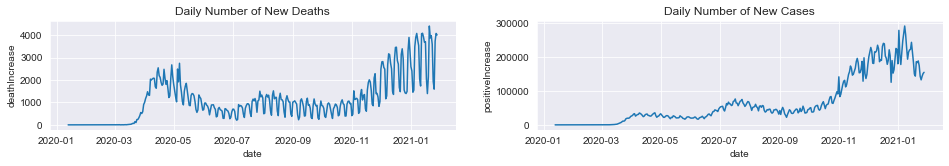

In [174]:
# plot target variables
fig, ax = plt.subplots(1, 2, figsize=(16,2))
sns.lineplot(data=df.deathIncrease, ax=ax[0])
ax[0].set_title('Daily Number of New Deaths')
sns.lineplot(data=df.positiveIncrease, ax=ax[1])
ax[1].set_title('Daily Number of New Cases')
# plt.subplots_adjust(hspace = 0.5)

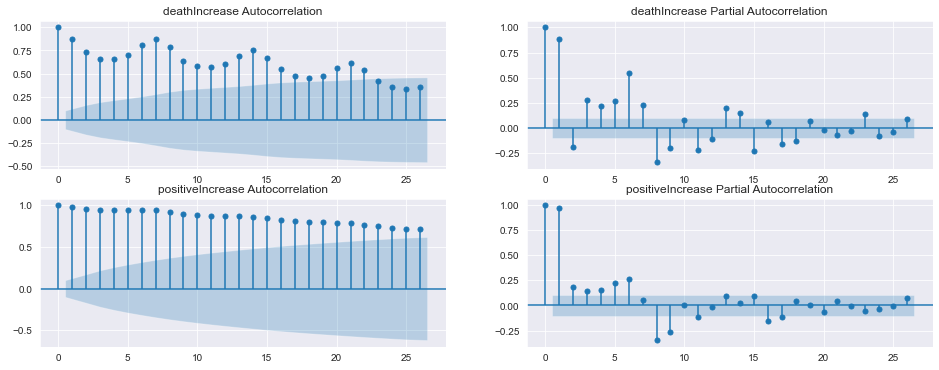

In [195]:
# Plot deaths ACF & PACF
fig, ax = plt.subplots(2, 2, figsize=(16,6))
plot_acf(df.deathIncrease, title='deathIncrease Autocorrelation', ax=ax[0][0]);
plot_pacf(df.deathIncrease, title='deathIncrease Partial Autocorrelation', ax=ax[0][1]);
plot_acf(df.positiveIncrease, title='positiveIncrease Autocorrelation', ax=ax[1][0]);
plot_pacf(df.positiveIncrease, title='positiveIncrease Partial Autocorrelation', ax=ax[1][1]);

### Dickey-Fuller Test

In [182]:
def stationarity_check(TS):       
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)     
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()    
    # Plot rolling statistics:
    #fig = plt.figure(figsize=(12,6))
    orig = sns.lineplot(data=TS, palette=['blue'],label='Original')
    mean = sns.lineplot(data=roll_mean, palette=['red'], label='Rolling Mean')
    std = sns.lineplot(data=roll_std, palette=['black'], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])                   
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.deathIncrease)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

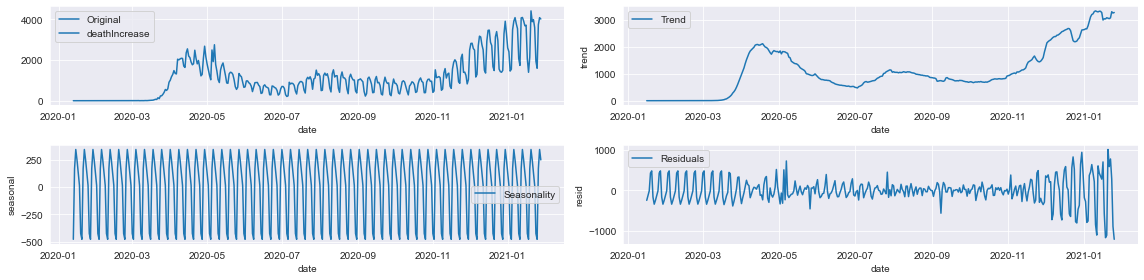

In [173]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.deathIncrease, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

In [175]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.positiveIncrease)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

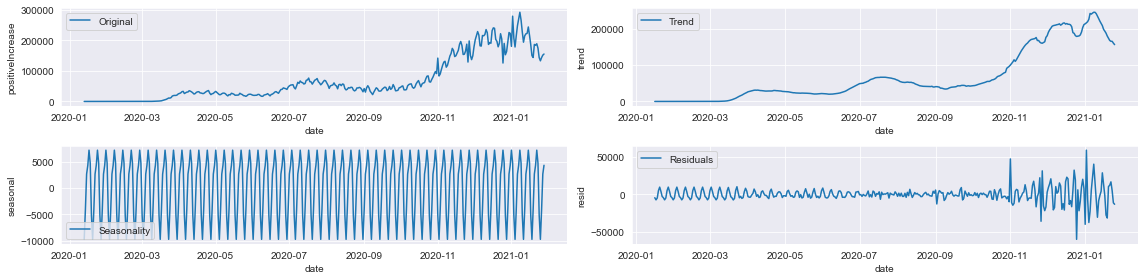

In [176]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.positiveIncrease, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

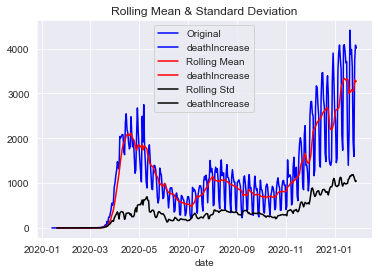

Results of Dickey-Fuller Test: 

Test Statistic                  -0.951804
p-value                          0.770434
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64


In [183]:
stationarity_check(df.deathIncrease)

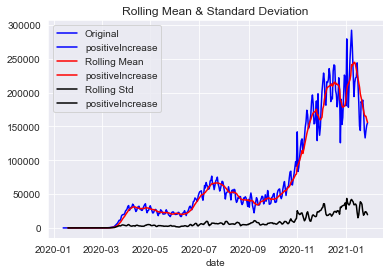

Results of Dickey-Fuller Test: 

Test Statistic                  -0.888697
p-value                          0.791672
#Lags Used                      15.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [184]:
stationarity_check(df.positiveIncrease)

In [187]:
# Plot a log transform
deaths_log = np.log(deaths)
stationarity_check(np.log(df.deathIncrease))

<ipython-input-187-acead6ea8413>:2: RuntimeWarning: divide by zero encountered in log
  deaths_log = np.log(deaths)


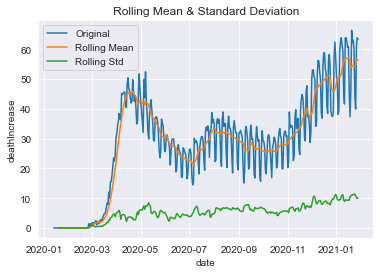

Results of Dickey-Fuller Test: 

Test Statistic                  -1.826656
p-value                          0.367311
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64


In [188]:
# Plot a square root transform
stationarity_check(np.sqrt(df.deathIncrease))

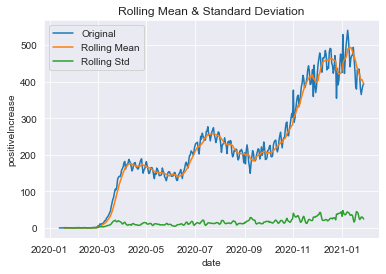

Results of Dickey-Fuller Test: 

Test Statistic                  -1.437175
p-value                          0.564330
#Lags Used                      15.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [189]:
# Plot a square root transform
stationarity_check(np.sqrt(df.positiveIncrease))

In [41]:
# Subtract the moving average from the log transformed data
deaths_data_minus_roll_mean = deaths_log - deaths_roll_mean
pos_data_minus_roll_mean = pos_log - pos_roll_mean

# Drop the missing values
deaths_data_minus_roll_mean.dropna(inplace=True)
pos_data_minus_roll_mean.dropna(inplace=True)

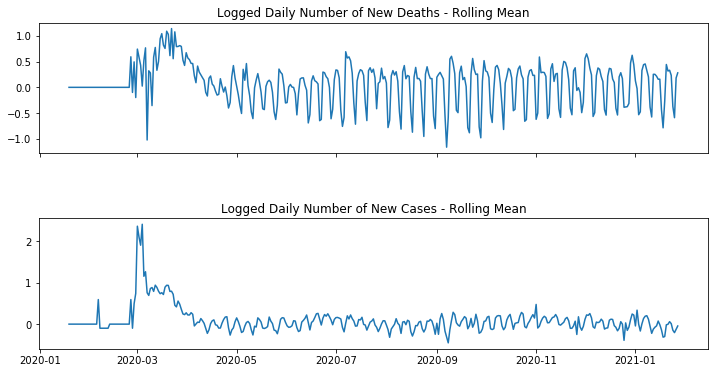

In [42]:
# replot target variables
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
axs[0].plot(deaths_data_minus_roll_mean)
axs[0].set_title('Logged Daily Number of New Deaths - Rolling Mean')
axs[1].plot(pos_data_minus_roll_mean)
axs[1].set_title('Logged Daily Number of New Cases - Rolling Mean')
plt.subplots_adjust(hspace = 0.5)
plt.show()

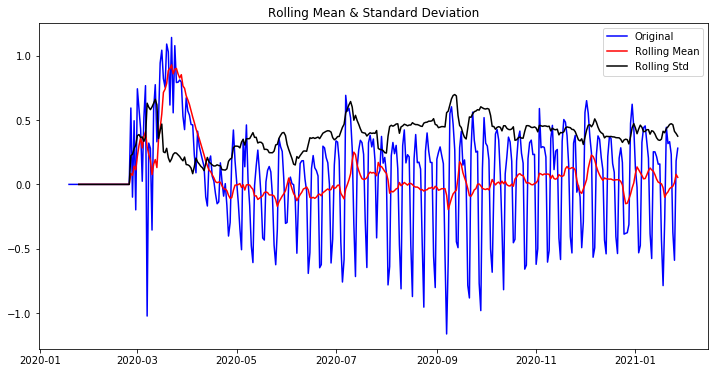

Results of Dickey-Fuller Test: 

Test Statistic                  -2.892933
p-value                          0.046176
#Lags Used                      16.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


In [43]:
stationarity_check(deaths_data_minus_roll_mean)

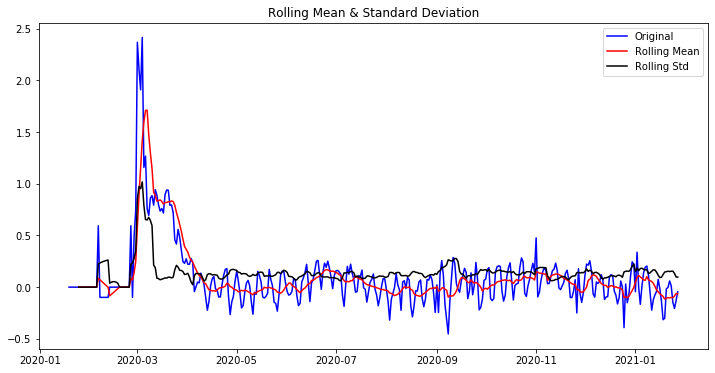

Results of Dickey-Fuller Test: 

Test Statistic                  -2.723401
p-value                          0.070076
#Lags Used                      13.000000
Number of Observations Used    361.000000
Critical Value (1%)             -3.448595
Critical Value (5%)             -2.869580
Critical Value (10%)            -2.571053
dtype: float64


In [44]:
stationarity_check(pos_data_minus_roll_mean)

## Modeling

### SARIMAX

#### SARIMAX Grid Search

In [11]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(1, 2)
d = range(1, 2)
q = range(1, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

p = range(0, 2)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [12]:
"""UNCOMMENT CELL BELOW TO RUN GRID SEARCH"""

'UNCOMMENT CELL BELOW TO RUN GRID SEARCH'

In [13]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(deaths,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}7 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# pickle grid parameters
pickle_out = open("death_grid.pickle","wb")
pickle.dump(ans_df, pickle_out)
pickle_out.close()

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 0, 7)7 : AIC Calculated =5746.266173965792


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 7)7 : AIC Calculated =5458.786417097692


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 2, 7)7 : AIC Calculated =5268.744129411599
ARIMA (1, 1, 1) x (0, 1, 0, 7)7 : AIC Calculated =5318.347478084827


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 7)7 : AIC Calculated =5121.7412021643895


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 7)7 : AIC Calculated =5033.122778617704


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 0, 7)7 : AIC Calculated =5302.963161979831


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages

ARIMA (1, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =5219.015666401652
ARIMA (1, 1, 1) x (1, 0, 2, 7)7 : AIC Calculated =5117.656980056081


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =5158.500451258868


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =5123.740584658573


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 7)7 : AIC Calculated =5033.706429096788


In [14]:
# load grid parameters
ans_df = pd.read_pickle('death_grid.pickle')

#### SARIMAX Model

In [15]:
# Check grid search results
ans_df.loc[ans_df['aic'].idxmin()][0], ans_df.loc[ans_df['aic'].idxmin()][1]

((1, 1, 1), (0, 1, 2, 7))

In [16]:
ARIMA_MODEL = SARIMAX(endog=np.log(deaths),
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0862      0.082     -1.050      0.294      -0.247       0.075
ma.L1         -0.3789      0.076     -4.968      0.000      -0.528      -0.229
ma.S.L7       -0.6229      0.034    -18.306      0.000      -0.690      -0.556
ma.S.L14      -0.0834      0.041     -2.050      0.040      -0.163      -0.004
sigma2         0.0659      0.003     20.059      0.000       0.059       0.072


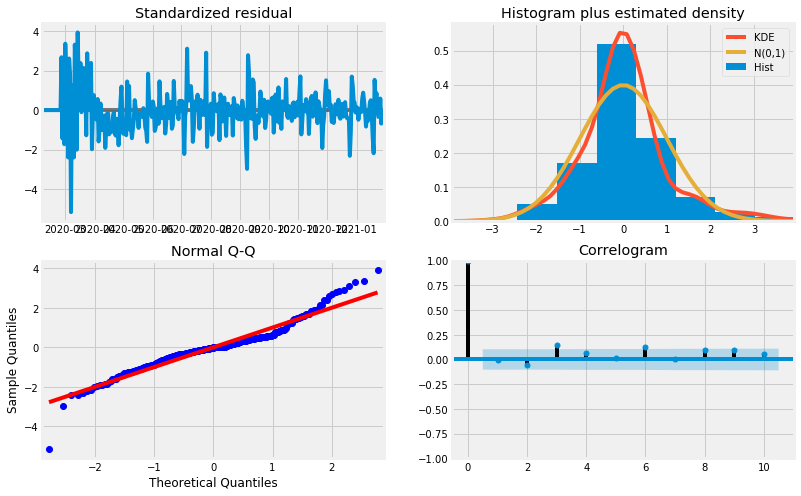

In [17]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [18]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=deaths.index[-60], dynamic=False)
pred_conf = pred.conf_int()

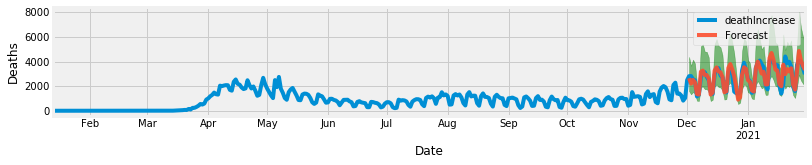

In [19]:
# Plot real vs predicted values along with confidence interval

plt.rcParams['figure.figsize'] = 12, 2

# Plot observed values
ax = deaths.plot(label='observed')

# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [20]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-60:]

# Compute the mean square error
mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 217982.77
The Root Mean Squared Error of our forecasts is 466.89


In [21]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths.index[-30], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

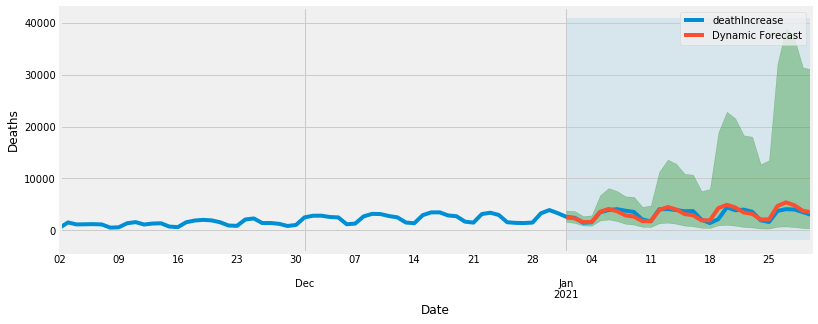

In [22]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths.index[-30], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1])

plt.legend()
plt.show()

In [23]:
# Extract the predicted and true values of our time series
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)

# Compute the mean square error
mse = ((deaths_forecasted - deaths.deathIncrease[-30:]) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 432067.17
The Root Mean Squared Error of our forecasts is 657.32


In [24]:
# Get forecast 14 days ahead in future
prediction = output.get_forecast(steps=14)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

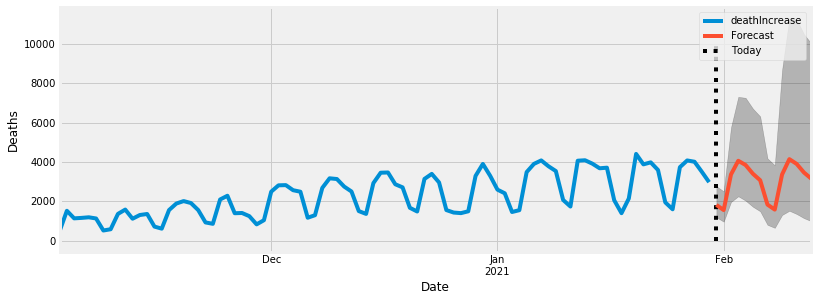

In [25]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1]+pd.DateOffset(14))
plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()
plt.show()

## Facebook Prophet

In [72]:
from fbprophet import Prophet

In [240]:
# ts.index.name = 'ds'
# ts = ts.reset_index()
# ts = ts.rename(columns={'timeline': 'y'})

In [279]:
fb_death = pd.DataFrame()
fb_death['y'] = df.deathIncrease
fb_death.reset_index(inplace=True)

In [303]:
death_train_fb, death_test_fb = fb_death[:-100], fb_death[-100:]

In [281]:
model_death = Prophet(interval_width=0.95)
model_death.fit(death_train_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [282]:
future_dates = model_death.make_future_dataframe(periods=100, freq='D')
forecast_death = model_death.predict(future_dates)
forecast_death.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-13,-230.220725,-1283.996312,319.097694,-230.220725,-230.220725,-286.952172,-286.952172,-286.952172,-286.952172,-286.952172,-286.952172,0.0,0.0,0.0,-517.172898
1,2020-01-14,-216.839971,-953.395119,742.978656,-216.839971,-216.839971,100.930128,100.930128,100.930128,100.930128,100.930128,100.930128,0.0,0.0,0.0,-115.909843
2,2020-01-15,-203.459216,-869.988754,824.642792,-203.459216,-203.459216,202.074659,202.074659,202.074659,202.074659,202.074659,202.074659,0.0,0.0,0.0,-1.384556
3,2020-01-16,-190.078461,-871.443257,745.717702,-190.078461,-190.078461,153.433201,153.433201,153.433201,153.433201,153.433201,153.433201,0.0,0.0,0.0,-36.645260
4,2020-01-17,-176.697706,-966.560399,818.645612,-176.697706,-176.697706,100.432887,100.432887,100.432887,100.432887,100.432887,100.432887,0.0,0.0,0.0,-76.264819


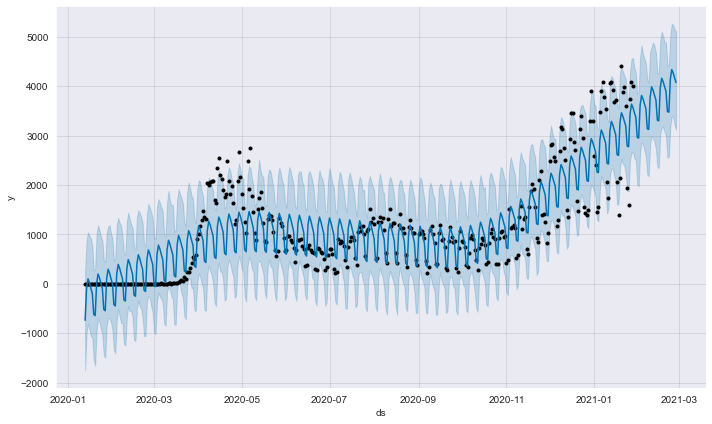

In [254]:
model_death.plot(forecast_death, uncertainty=True);

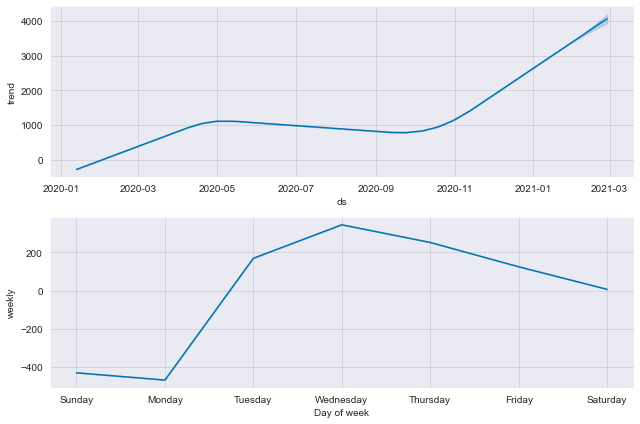

In [258]:
model_death.plot_components(forecast_death);

In [308]:
fb_positive = pd.DataFrame()
fb_positive['y'] = df.positiveIncrease
fb_positive.reset_index(inplace=True)

In [309]:
positive_train_fb, positive_test_fb = fb_positive[:-100], fb_positive[-100:]

In [311]:
model_positive = Prophet(interval_width=0.95)
model_positive.fit(positive_train_fb)

forecast_positive = model_positive.predict(future_dates)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## LSTM (long short-term memory) Networks

In [313]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [314]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [333]:
df_lstm = pd.DataFrame()
df_lstm['death'] = df.deathIncrease

In [334]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [335]:
train, test = dataset[:-100], dataset[-100:]

In [336]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [337]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [340]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [341]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

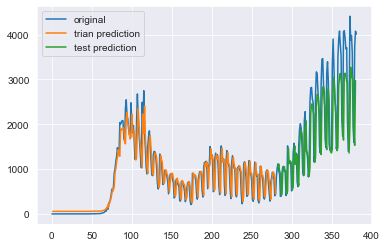

In [346]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(trainPredictPlot,label='trian prediction')
plt.plot(testPredictPlot,label='test prediction')
plt.legend()

## Evaluation

### metrics in ARMA

### metrics in ARIMA

### metrics in SARIMAX

### metrics in Facebook Prophet

In [305]:
# calculate root mean squared error
train_rmse_death_fb = mean_squared_error(death_train_fb['y'], forecast_death['yhat'][:-100], squared=False)
test_rmse_death_fb = mean_squared_error(death_test_fb['y'], forecast_death['yhat'][-100:], squared=False)
print('Facebook Prophet deathIncrease train RMSE: {:.2f}'.format(train_rmse_death_fb))
print('Facebook Prophet deathIncrease test RMSE: {:.2f}'.format(test_rmse_death_fb))
# calculate mean absolute error
train_mae_death_fb = mean_absolute_error(death_train_fb['y'], forecast_death['yhat'][:-100])
test_mae_death_fb = mean_absolute_error(death_test_fb['y'], forecast_death['yhat'][-100:])
print('Facebook Prophet deathIncrease train MAE: {:.2f}'.format(train_mae_death_fb))
print('Facebook Prophet deathIncrease test MAE: {:.2f}'.format(test_mae_death_fb))

Facebook Prophet deathIncrease train RMSE: 432.03
Facebook Prophet deathIncrease test RMSE: 1929.95
Facebook Prophet deathIncrease train MAE: 321.32
Facebook Prophet deathIncrease test MAE: 1579.82


In [312]:
# calculate root mean squared error
train_rmse_positive_fb = mean_squared_error(positive_train_fb['y'], forecast_positive['yhat'][:-100], squared=False)
test_rmse_positive_fb = mean_squared_error(positive_test_fb['y'], forecast_positive['yhat'][-100:], squared=False)
print('Facebook Prophet positiveIncrease train RMSE: {:.2f}'.format(train_rmse_positive_fb))
print('Facebook Prophet positiveIncrease test RMSE: {:.2f}'.format(test_rmse_positive_fb))
# calculate mean absolute error
train_mae_positive_fb = mean_absolute_error(positive_train_fb['y'], forecast_positive['yhat'][:-100])
test_mae_positive_fb = mean_absolute_error(positive_test_fb['y'], forecast_positive['yhat'][-100:])
print('Facebook Prophet positiveIncrease train MAE: {:.2f}'.format(train_mae_positive_fb))
print('Facebook Prophet positiveIncrease test MAE: {:.2f}'.format(test_mae_positive_fb))

Facebook Prophet positiveIncrease train RMSE: 9710.12
Facebook Prophet positiveIncrease test RMSE: 132270.15
Facebook Prophet positiveIncrease train MAE: 8027.66
Facebook Prophet positiveIncrease test MAE: 122132.51


### metrics in LSTM Networks

In [343]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks deathIncrease train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks deathIncrease test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks deathIncrease train MAE: {:.2f}'.format(trainScore_mae))
print('LSTM Networks deathIncrease test MAE: {:.2f}'.format(testScore_mae))

LSTM Networks deathIncrease train RMSE: 275.27
LSTM Networks deathIncrease test RMSE: 788.28
LSTM Networks deathIncrease train MAE: 183.45
LSTM Networks deathIncrease test MAE: 563.24


## Deployment

web app can be furtherly tested and released.